In this notebook, we will explore the energy minimization of the CPWL initialised model.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import scipy as sp
import matplotlib.pyplot as plt


###################################
#### Sparse approach
###################################
def theta(x_arr):
    return (x_arr>=0.5)



def fill_max_sparse_1(input_size):
    max_arr = -np.array([[1, -1], [0, 1], [0, -1]])
    iden = sp.sparse.eye(input_size)
    max_sparse = sp.sparse.bsr_matrix(max_arr)
    matrix = sp.sparse.kron(iden, max_sparse)
    # matrix = np.kron(np.eye(input_size),max_arr)
    # matrix = sp.sparse.bsr_matrix(matrix)
    return matrix.T


def fill_max_sparse_2(input_size):
    array = -sp.sparse.bsr_matrix([1, 1, -1])
    iden = sp.sparse.eye(input_size)
    matrix = np.kron(np.eye(input_size), array)
    matrix = sp.sparse.kron(iden, array)
    return matrix.T


def para_sparse_matrices(*arg):
    result = []
    for mat in zip(*arg):
        sat = sp.sparse.block_diag(mat)
        result.append(sat)
    return result


def shape_to_model(dense_matrix, activ ="relu",train=True):
    shape_list = [a.shape for a in dense_matrix]
    print(shape_list)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(int(shap[0])))
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros', trainable=train)(input_mat)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
    model_matrix = tf.keras.Model(input_mat, net)
    mat_init = [b for a in dense_matrix for b in [a.toarray(), np.zeros(a.shape[1])]]
    model_matrix.set_weights(mat_init)
    return model_matrix




def shape_to_random_model(dense_matrix, activ ="relu",train=True):
    shape_list = [a.shape for a in dense_matrix]
    print(shape_list)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(int(shap[0])))
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros', trainable=train)(input_mat)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
    model_matrix = tf.keras.Model(input_mat, net)
    # mat_init = [b for a in dense_matrix for b in [a.toarray(), np.zeros(a.shape[1])]]
    # model_matrix.set_weights(mat_init)
    return model_matrix


def set_up_max_matrix(depth):
    result = []
    while depth != 0:
        result.append(fill_max_sparse_1(depth))
        result.append(fill_max_sparse_2(depth))
        depth = int(depth / 2)
    return result



def fill_min_sparse_1(input_size):
  max_arr = np.array([[-1,1],[0,-1],[0,1]])
  iden = sp.sparse.eye(input_size)
  max_sparse = sp.sparse.bsr_matrix(max_arr)
  matrix = sp.sparse.kron(iden,max_sparse)
  return matrix.T

def fill_min_sparse_2(input_size):
  array = sp.sparse.bsr_matrix([-1,-1,1])
  iden = sp.sparse.eye(input_size)
  matrix = np.kron(np.eye(input_size), array)
  matrix = sp.sparse.kron(iden,array)
  return matrix.T

def set_up_min_matrix(depth):
  result = []
  while depth != 0:
    result.append(fill_min_sparse_1(depth))
    result.append(fill_min_sparse_2(depth))
    depth = int(depth/2)
  return result


def invert_matrix(point_list):
    ones = np.ones((point_list.shape[0],1))
    point_list = np.concatenate((point_list,ones) , axis=1)
    zeros = np.zeros((point_list.shape[0]))
    zeros[0] = 1
    solution = np.linalg.inv(point_list)@zeros
    return solution

def RAI(shape, dtype=None):
  fan_in,fan_out = shape
  """Randomized asymmetric initializer.
  6 It draws samples using RAI where fan_in is the number of input units in the weight
  tensor and fan_out is the number of output units in the weight tensor.
  7 """
  V = np.random.randn(fan_out, fan_in + 1) * 0.6007 / fan_in ** 0.5
  for j in range(fan_out):
    k = np.random.randint(0, high=fan_in + 1)
    V[j, k] = np.random.beta(2, 1)
    W = V[:, :-1].T
    b = V[:, -1]
  return W.astype(np.float32), b.astype(np.float32)

In [ ]:
point_invert = np.array([[1],[2]])
print(invert_matrix(point_invert))

[-1.  2.]


In [ ]:
xmin=0
xmax=1

NN = 20

x = np.linspace(0,1,NN)
grid = np.meshgrid(x,x)

X, Y = np.mgrid[xmin:xmax:3j, xmin:xmax:3j]
positions = np.vstack([X.ravel(), Y.ravel()])

positions = positions.T
dim = positions.shape[0]
ones = np.linspace(0,dim-1,dim).astype(int)

res = pd.DataFrame(x)
#res = np.column_stack([ones.T,positions])

print(res.head())
print(1/(NN-1))

## generate the nearest neighbours
pat_1dn = res
pat_1dn.columns=['point']
#print(res.shift(periods=-1))
#pat_1dn['prev'] = (pat_1dn.index -1).astype(int) 
pat_1dn['prev'] = pat_1dn.point - 1/(NN-1)
pat_1dn['next'] = pat_1dn.point + 1/(NN-1)
#pat_1dn['next'] = (pat_1dn.index +1).astype(int) 
print(pat_1dn)
#pat_1dn['next'] = res.shift(periods= -1).values

res['glob_linp'] = [invert_matrix(np.array([[a],[b]])) for a,b in zip(pat_1dn.point,pat_1dn.prev) ]
res['glob_linn'] = [invert_matrix(np.array([[a],[b]])) for a,b in zip(pat_1dn.point,pat_1dn.next) ]
global_lin = res[['glob_linp','glob_linn']]

stacked_tf =[tf.convert_to_tensor(aa) for aa in global_lin.stack().values]
print(stacked_tf)
print(x)

          0
0  0.000000
1  0.052632
2  0.105263
3  0.157895
4  0.210526
0.05263157894736842
       point      prev      next
0   0.000000 -0.052632  0.052632
1   0.052632  0.000000  0.105263
2   0.105263  0.052632  0.157895
3   0.157895  0.105263  0.210526
4   0.210526  0.157895  0.263158
5   0.263158  0.210526  0.315789
6   0.315789  0.263158  0.368421
7   0.368421  0.315789  0.421053
8   0.421053  0.368421  0.473684
9   0.473684  0.421053  0.526316
10  0.526316  0.473684  0.578947
11  0.578947  0.526316  0.631579
12  0.631579  0.578947  0.684211
13  0.684211  0.631579  0.736842
14  0.736842  0.684211  0.789474
15  0.789474  0.736842  0.842105
16  0.842105  0.789474  0.894737
17  0.894737  0.842105  0.947368
18  0.947368  0.894737  1.000000
19  1.000000  0.947368  1.052632
[<tf.Tensor: shape=(2,), dtype=float64, numpy=array([19.,  1.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-19.,   1.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([19.,  0.])>, <tf.Tensor: shape

In [ ]:
from functools import partial
oner = True

def boundary(y):
  if oner:
    ret = np.ones_like(y)
  else:
    ret = (y*(1-y))**1
  return ret#(y*(1-y))**1 ## #

def boundary_arr(y):
  return np.array([1/a if a!=0 else 1 for a in boundary(y)],dtype=object)

def func_approx(x_len):
  return np.sin(1*np.pi*x_len) /(1*np.pi)  *boundary_arr(x_len) #(x*(1-x))**0.5 ##/ bounds # 


def shape_to_model_glob_lin(activ ="relu",train=True):
    minimum_list = set_up_min_matrix(1)
    dense_matrix = para_sparse_matrices(*[ minimum_list for i in range(NN)])
    shape_list = [a.shape for a in dense_matrix]
    stack_array = np.array(stacked_tf)
    print(shape_list)
    reg = tf.keras.regularizers.l1(l1=0.05)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(1))
            net = layers.Dense(shap[0], activation=activ, bias_initializer='zeros', trainable=True, kernel_regularizer
                               =reg, bias_regularizer =reg )(input_mat)
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train, kernel_regularizer
                               =reg, bias_regularizer =reg )(net)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train, kernel_regularizer
                               =reg, bias_regularizer =reg )(net)
    model_matrix = tf.keras.Model(input_mat, net)
    mat_init = [b for a in dense_matrix for b in [a.toarray(), np.zeros(a.shape[1])]]
    n_loc = stack_array.shape[0]
    print(n_loc)
    mat_init.insert(0,stack_array.T[-1,:].reshape(n_loc,))
    mat_init.insert(0,stack_array.T[0:-1,:].reshape(1,n_loc))
    model_matrix.set_weights(mat_init)
    new_model = tf.keras.Sequential()
    new_model.add(model_matrix)
    new_model.add(layers.Dense(1,use_bias=True))
    new_model.compile()
    coefficients = func_approx(x).reshape(NN,1)
    if not oner:
      coefficients[0] = coefficients[1]
      coefficients[-1] = coefficients[-2]
    new_model.layers[-1].set_weights([coefficients,np.array([-0.00])])
    # new_model.layers[-1].set_weights([new_df['Values'].values.reshape(9,1),np.array([0])])
    return new_model


def flattened_model(depth,width,activ='relu'):
  for i in range(depth):
    # print(i)
    if i == 0:
      input_mat = tf.keras.Input(shape=(1))
    elif i==1:
      net = layers.Dense(width, activation=activ)(input_mat) #, bias_initializer='zeros',kernel_initializer='zeros'
    elif i==depth-1:
      net_end = layers.Dense(1, activation=activ)(net)
    else:
      net = layers.Dense(width, activation=activ)(net)
  model_matrix = tf.keras.Model(input_mat, net_end)
  return model_matrix


def random_to_model_glob_lin(activ ="relu",train=True):
    minimum_list = set_up_min_matrix(1)
    dense_matrix = para_sparse_matrices(*[minimum_list for i in range(NN)])
    shape_list = [a.shape for a in dense_matrix]
    stack_array = np.array(stacked_tf)
    print(shape_list)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(1))
            net = layers.Dense(shap[0], activation=activ, bias_initializer='zeros', trainable=True)(input_mat)
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
    model_matrix = tf.keras.Model(input_mat, net)
    new_model = tf.keras.Sequential()
    new_model.add(model_matrix)
    new_model.add(layers.Dense(1))
    #new_model.layers[-1].set_weights([func_approx(x), np.array([0])])
    #print(func_approx(x))
    new_model.compile()
    return new_model    

model_one_last = shape_to_model_glob_lin(train=True,activ=partial(tf.nn.leaky_relu, alpha=0.00))

#for i in range(NN):#
#  print(i)
model_one_last.summary()

[(40, 60), (60, 20)]
40
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 20)                3760      
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 3,781
Trainable params: 3,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
random_model= random_to_model_glob_lin(activ='relu')
#random_model.summary()

[(40, 60), (60, 20)]


In [ ]:
#net_2 = tf.keras.Input(shape=(1))
#net_22 = layers.Dense(25, activation='relu', bias_initializer='zeros',kernel_initializer='zeros')(net_2)
#net_222 = layers.Dense(1, activation='relu', bias_initializer='zeros',kernel_initializer='zeros')(net_22)


#model_flat = tf.keras.Model(net_2, net_222)

model_flat = flattened_model(5,42,activ='tanh') ### (15,30,60  ) #TODO: tanh activ #partial(tf.nn.leaky_relu, alpha=0.01)
model_flat.summary()#$3.842e-1$$3.842e-1$

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_39 (Dense)            (None, 42)                84        
                                                                 
 dense_40 (Dense)            (None, 42)                1806      
                                                                 
 dense_41 (Dense)            (None, 42)                1806      
                                                                 
 dense_42 (Dense)            (None, 1)                 43        
                                                                 
Total params: 3,739
Trainable params: 3,739
Non-trainable params: 0
_________________________________________________________________


In [ ]:
domain = np.linspace(0,1,200).reshape((200,1))
model_flat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=9e-5),
              loss=tf.keras.losses.MAE)
hist = model_flat.fit(domain,model_one_last(domain),epochs=1000)

L2 loss with boundary: 0 -0.24945025842517193
True loss 0.003151460304637289
L2 loss with boundary: 100 -0.24977479044045875
True loss 0.0022415016803486775
L2 loss with boundary: 200 -0.2501434985957762
True loss 0.0017721975037665735
L2 loss with boundary: 300 -0.25049265966282275
True loss 0.0017697513539562896
L2 loss with boundary: 400 -0.25082872246880594
True loss 0.002231173804177693
L2 loss with boundary: 500 -0.25114886565209127
True loss 0.0031670936742565574
L2 loss with boundary: 600 -0.25150113428277476
True loss 0.004546803840767204
L2 loss with boundary: 700 -0.2517902350602201
True loss 0.00637085248215864
L2 loss with boundary: 800 -0.2520661926318064
True loss 0.008650804695869305
L2 loss with boundary: 900 -0.25232919875712395
True loss 0.011350998692336424
L2 loss with boundary: 1000 -0.25256748500526643
True loss 0.014485619989403013
L2 loss with boundary: 1100 -0.25275345488986534
True loss 0.018031383135643668
L2 loss with boundary: 1200 -0.25296888042383536
Tru

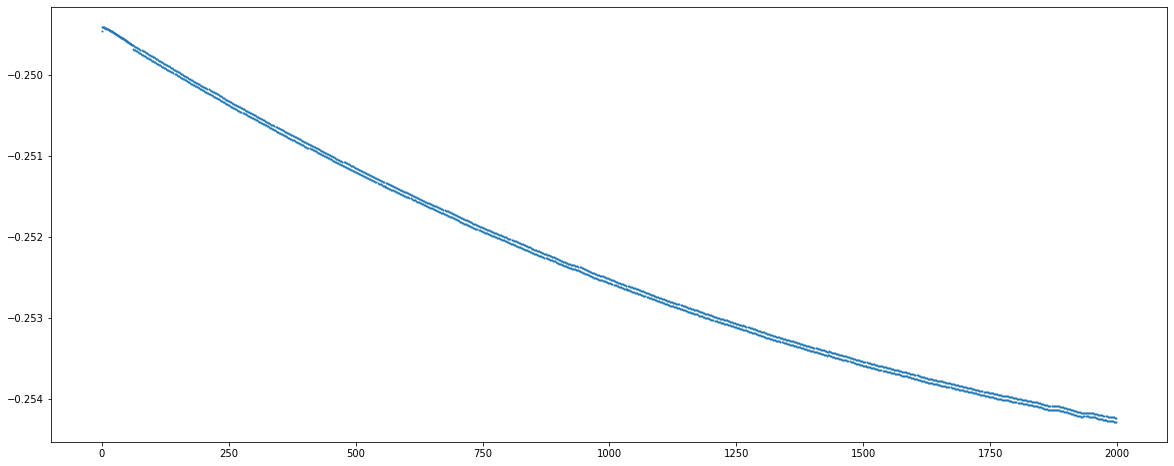

In [ ]:

domain = np.linspace(0,1,200).reshape((200,1))
domain = np.concatenate([domain,np.ones_like(domain)],axis=1)
#z = np.ones_like(x_len)# np.array(np.sin(np.pi*x_len),dtype=float)
func_train = np.sin(np.pi*domain)*np.pi

def train_model_full(model_train, Num=2000,train_steps=1500):
    x_arr = []
    err_arr = []
    true_err = []
    x_len = np.linspace(0,1,Num).reshape((Num,1))
    #z = np.ones_like(x_len)# np.array(np.sin(np.pi*x_len),dtype=float)
    z = np.sin(1*np.pi*x_len)*np.pi*1
    z_result = np.sin(1*np.pi*x_len) /(1*np.pi)#func_approx(x_len)#np.sin(np.pi*x_len)/np.pi ##x(1-x)^^0.5
    #print(z)
    #bounds = boundary(x_len).reshape((N,1))
    x_tensor = tf.convert_to_tensor(x_len, dtype=tf.float64)
    loss_min = 10
    bounds = boundary(x_tensor)#.reshape((Num,1))
    bounds = tf.convert_to_tensor(bounds, dtype=tf.float64)
    for step in range(0,train_steps):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_tensor)
            tape.watch(bounds)
            #ones = tf.convert_to_tensor(np.ones((x_tensor.shape[0],1)),dtype=tf.float64)
            #test = tf.concat([x_tensor, ones],axis=1)
            #tape.watch(test)
            output = model_train(x_tensor, training=True)
            #tape.watch(bounds)
            #plt.plot(x_len,z-output)
            #z = tf.reshape(z, [-1])
            output = tf.cast(output,dtype=tf.float64)
            #plt.plot(x_tensor,output)
            output = tf.reshape(output,shape=(Num,1))* bounds
            #plt.plot(x_tensor,output)
            y_x = tape.gradient(output,x_tensor)
            y_xx = tape.gradient(y_x,x_tensor)
            #print(y_x.shape,output.shape,x_tensor.shape,bounds.shape)
            #plt.plot(x_tensor,y_x)
            #plt.plot(x_tensor,bounds)
            #plt.plot(x_tensor,output)
            #break
            z = tf.reshape(z,shape=(Num,1)) 
            # energy pot and en
            # print(y_x.shape,output.shape,z.shape)
            # break
            kin = 0.5*tf.reduce_sum(y_x**2, axis=1)
            pot = tf.multiply( z,output)
            # the bare energy loss
            #print(output[0],output[-1])
            #break
            #loss = tf.reduce_mean( tf.math.square(y_xx + z))
            ############################**
            # Old loss
            loss = tf.reduce_mean(input_tensor=(kin-pot))
            # with boundary conditions as loss
            loss = loss + 80.0*output[0]**2 + 80.0*output[-1]**2
            #true_loss = tf.redu
            true_loss = tf.reduce_sum( tf.square(z_result - output) )#**0.5
            if loss < loss_min:
              loss_min = loss
            #print(loss)
            #break
              #+ 
            if  step == 0:
                loss_first = loss
                loss_direct = loss #/ tf.reduce_sum((output)**2)#**.80
            else:
                loss_direct = loss #+ 500*tf.math.square(output[0]) + 500*tf.math.square(output[-1]) #/ tf.reduce_sum((output)**2)
        loss = loss # + 0.25
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-9) #3e-6:full  1e-5   0.000003 2e-6 for tanh
        grads_d = tape.gradient(loss_direct, model_train.trainable_weights)
        optimizer.apply_gradients((grad,var) for (grad,var) in  zip(grads_d, model_train.trainable_weights)) # grad is not None
        if step % 100 == 0:
            print(
                "L2 loss with boundary:",
                step, float(loss_direct)
            )
            print('True loss', float(true_loss))
            # print("reduced loss:", float(loss_direct))
        x_arr.append(step)
        err_arr.append(float(loss))
        true_err.append(true_loss)
    #print('error:', (loss_first))
    #print('error min:', float(loss_min+0.25))
    plt.figure(figsize=(20,8))
    plt.scatter(x_arr,err_arr,s=1)
    #plt.yscale('log')
    return x_arr,err_arr,true_err

x_fem,y_fem,t_fem = train_model_full(model_one_last,Num=10000, train_steps=2000) #Num=10000 half training steps??

In [ ]:
print(np.min(t_pinn),np.min(t_fem)) 
#10: 0.0383636793095105 0.04992751230444976
#15: 0.01693896285361885 0.005610998295411345
#20: 0.11353280036361926 0.001710624511995608

0.11353280036361926 0.001710624511995608


In [ ]:
print(len(model_flat.get_weights()))

6


In [ ]:
#print(y_r_rel[::-1])
f, (ax1, ax2) = plt.subplots(1, 2,sharex=True) #plt.figure())
f.set_figheight(15)
f.set_figwidth(15)
# print((y))
#plt.plot(x_step,y_err) 
#plt.scatter(x_step55,y_err55,s=1,label='First and Last',marker='x')
#plt.plot(x_cont_all,y_cont_all, label='random flat boundary')
ax1.plot(x_cont,y_cont+np.ones_like(y_cont)*2.6, label='1 hidden layer relu + offset')
ax2.plot(x_cont,t_err, label='true L2 error')
#plt.plot(x_s_relu,y_s_relu, label='ReLU')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(-1,3000)
plt.xlabel('Ierations', fontsize=30)
plt.ylabel('Energy and MAE', fontsize=30)
plt.legend() #fontsize=30

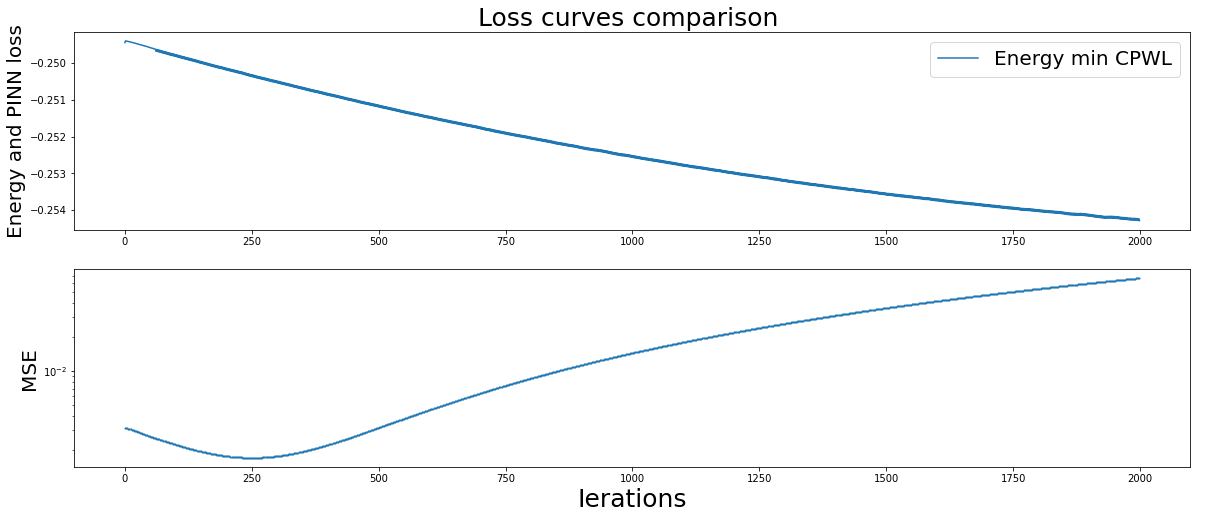

In [ ]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

#ax1.plot(x_pinn,y_pinn, label='PINN loss')
#ax2.scatter(x_pinn,t_pinn, label='true L2 error PINN',s=0.5)

ax1.plot(x_fem,y_fem, label='Energy min CPWL')
ax2.scatter(x_fem,t_fem, label='true L2 error',s=0.5)

#ax1.plot(x_en,y_en, label='Energy min Random')
#ax2.scatter(x_en,t_en, label='true L2 error',s=0.5)

# Set common labels
ax.set_xlabel('Ierations', fontsize=25)
ax.set_xlim(-1,200)
#ax2.set_xlim(-1,1000)
#ax.set_ylabel('Energy and MAE', fontsize=30)
ax2.set_ylabel('MSE', fontsize=20)
ax1.set_ylabel('Energy and PINN loss', fontsize=20)
ax2.set_yscale('log')
ax.set_title('Loss curves comparison ', fontsize=25) #with boundary function
ax1.legend(fontsize=20)
#ax2.legend(fontsize=20)
#ax1.set_title('ax1 title')
#ax2.set_title('ax2 title')

#plt.savefig('common_labels.png', dpi=300)

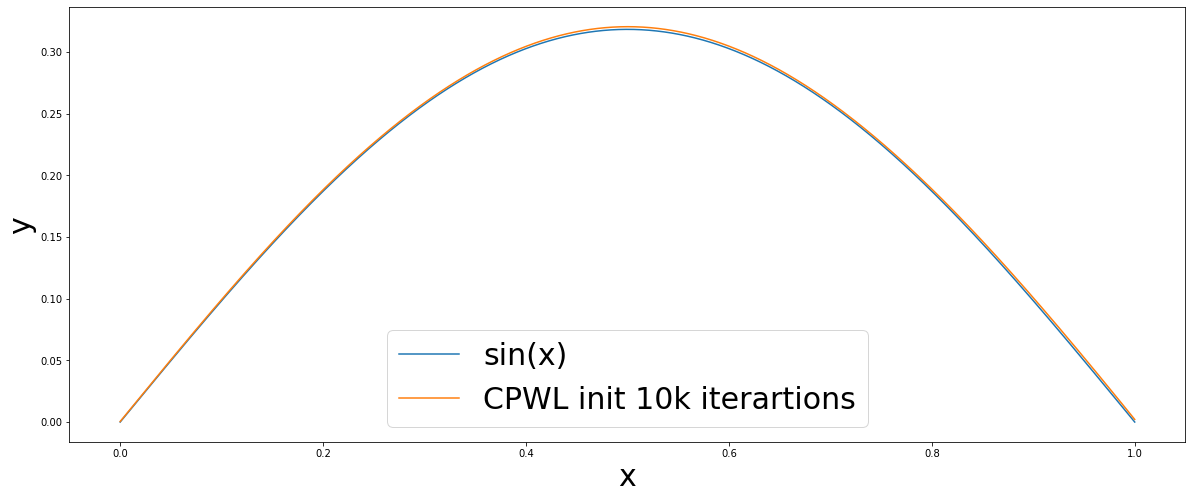

(<Figure size 1440x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff3d0b99690>)

In [ ]:
def plot_decision_boundary_full(model_plot, steps=2000, cmap='Paired'):
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot()#projection='3d'
    x_span = np.linspace(0, 1, steps)
    # print(len(x_span))
    test = np.c_[x_span, np.ones(steps)]
    func_values = model_plot.predict(x_span)*boundary(x_span).reshape(steps,1)
    #func_a = model_a.predict(x_span)*boundary(x_span).reshape(steps,1)
    # m = np.max(np.abs(func_values))
    #z = func_values.reshape(xx.shape)*boundary(xx,yy)
    zz = func_approx(x_span)*boundary(x_span) #np.sin(np.pi*x_span)/(np.pi)#*np.sin(np.pi*yy)/(2*np.pi)# *boundary
    #ax = fig.add_subplot(projection='3d')
    
    #ax.plot(x_span, func_a, label='CPWL init 10k iterartions + boundary')
    ax.plot(x_span,zz,label='sin(x)')
    
    ax.plot(x_span, func_values - np.ones_like(func_values)*0.0, label='CPWL init 10k iterartions')
    plt.xlabel('x', fontsize=30)
    plt.ylabel('y', fontsize=30)
    plt.legend(fontsize=30)
    # ax.plot(x_span,zz*m)
    #ax.contourf(xx, yy, z, alpha=0.7,cmap=plt.cm.rainbow)
    #plt.colorbar(PCM,ax=ax)
    #plt.imshow
    plt.show()
    # plt.savefig("fem_trained.png")
    return fig, ax

plot_decision_boundary_full(model_flat)
#model_a = model_one_last
#model_one_last([[0.5,1]])

In [ ]:
N=10000
x_len = np.linspace(0,1,N).reshape((N,1))
#z = np.ones_like(x_len)# np.array(np.sin(np.pi*x_len),dtype=float)
z = np.sin(np.pi*x_len)/np.pi
nn_list = []
err_list = []
for NN in range(3,200):
  nn_list.append(NN)
  x = np.linspace(0,1,NN)
  res = pd.DataFrame(x)
  pat_1dn = res
  pat_1dn.columns=['point']
  pat_1dn['prev'] = pat_1dn.point - 1/(NN-1)
  pat_1dn['next'] = pat_1dn.point + 1/(NN-1)
  res['glob_linp'] = [invert_matrix(np.array([[a],[b]])) for a,b in zip(pat_1dn.point,pat_1dn.prev) ]
  res['glob_linn'] = [invert_matrix(np.array([[a],[b]])) for a,b in zip(pat_1dn.point,pat_1dn.next) ]
  global_lin = res[['glob_linp','glob_linn']]
  stacked_tf =[tf.convert_to_tensor(aa) for aa in global_lin.stack().values]
  def shape_to_model_glob_lin_loop(activ ="relu",train=True):
    minimum_list = set_up_min_matrix(1)
    dense_matrix = para_sparse_matrices(*[ minimum_list for i in range(NN)])
    shape_list = [a.shape for a in dense_matrix]
    stack_array = np.array(stacked_tf)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(2))
            net = layers.Dense(shap[0], activation=activ, bias_initializer='zeros', trainable=train)(input_mat)
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
    model_matrix = tf.keras.Model(input_mat, net)
    mat_init = [b for a in dense_matrix for b in [a.toarray(), np.zeros(a.shape[1])]]
    mat_init.insert(0,np.zeros(stack_array.shape[0]))
    mat_init.insert(0,stack_array.T)
    model_matrix.set_weights(mat_init)
    new_model = tf.keras.Sequential()
    new_model.add(model_matrix)
    new_model.add(layers.Dense(1))
    new_model.compile()
    new_model.layers[-1].set_weights([func_approx(x).reshape(NN,1), np.array([0])])
    return new_model
  model_one_last_loop = shape_to_model_glob_lin_loop(train=False)
  test = np.c_[x_len, np.ones(x_len.shape[0])]
  func_values = model_one_last_loop.predict(test)
  err = np.mean((func_values-z)**2)
  err_list.append(err)

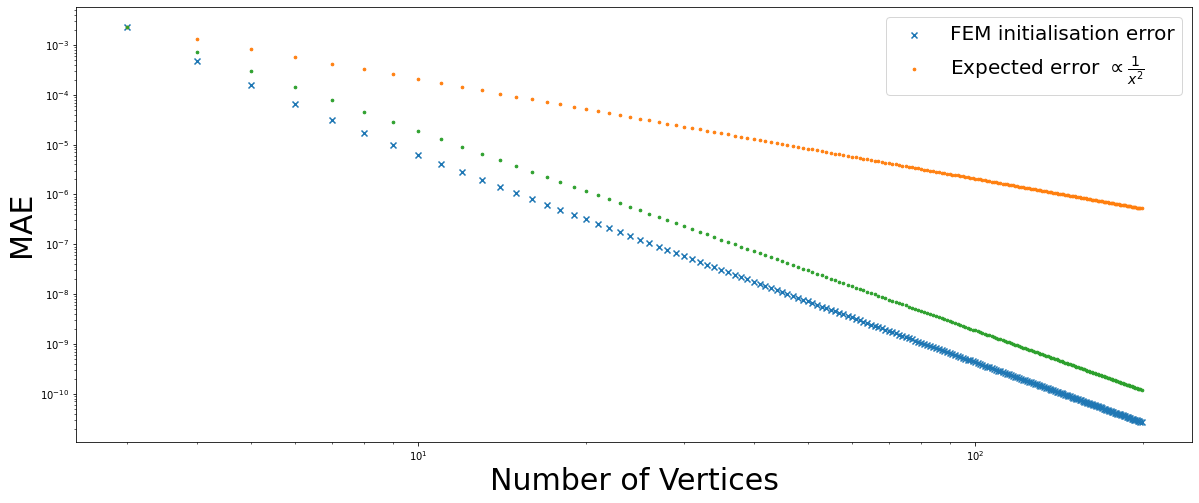

In [ ]:
plt.figure(figsize=(20,8))
plt.scatter(nn_list,err_list,marker='x')
plt.scatter(np.array(nn_list),err_list[0]*9/np.array(nn_list)**2, s=7)
plt.scatter(np.array(nn_list),err_list[0]*3**4/np.array(nn_list)**4, s=7)
#plt.scatter(np.array(nn_list),0.0002/np.array(nn_list)**3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Vertices', fontsize=30)
plt.ylabel('MAE', fontsize=30)
plt.legend(['FEM initialisation error',r"Expected error $\propto \frac{1}{x^{2}}$"], fontsize=20)

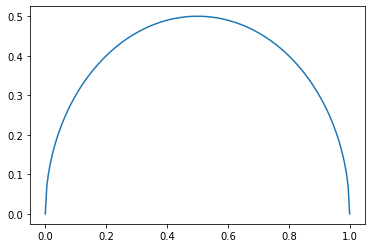

In [ ]:
plt.plot(domain, (domain*(1-domain))**0.5)